In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)
plt.set_cmap("viridis")

import itertools
import numpy as np

In [11]:
from carl.distributions import Normal
from carl.data import GK

true_A = 3.    # Parameter
true_B = 1.5   # Parameter
true_g = 2.    # Nuisance parameter
true_k = 0.5   # Constant

gk = GK(A=true_A, B=true_B, g=true_g, k=true_k)
X_true = gk.rvs(10000)

gk2 = GK(A=1., B=1., g=true_g, k=true_k)
X_2 = gk2.rvs(10000)

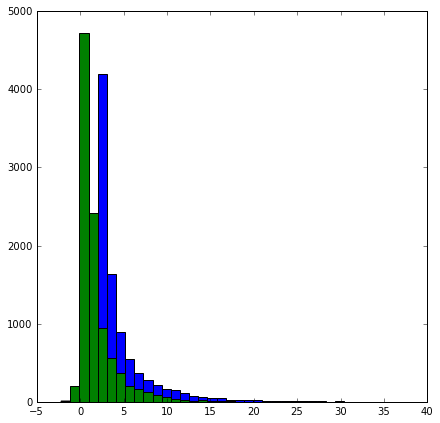

In [12]:
counts, bins, patches = plt.hist(X_true, bins=40)
_ = plt.hist(X_2, bins=bins)

In [4]:
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Build classification data
p1 = Normal(mu=np.mean(X_true), 
            sigma=np.std(X_true) * 4)

X, y = make_parameterized_classification(
    gk, p1, 200000, 
    [(gk.A, np.linspace(1, 5, num=20)), 
     (gk.B, np.linspace(1, 5, num=20)),
     (gk.g, np.linspace(1, 5, num=20))])

# Train parameterized classifier
clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(100, 100)))),
    [gk.A, gk.B, gk.g])
clf.fit(X, y)

//anaconda/envs/carl-notebooks/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ParameterizedClassifier(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100...=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)))]),
            params=[A, B, g])

In [5]:
from GPyOpt.methods import BayesianOptimization

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(x):
        v = np.zeros(len(x))
        
        for i, x_i in enumerate(x):
            v[i] = func(x_i)
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0): 
    print(theta)
    
    # Set parameter values
    gk.A.set_value(theta[0])
    gk.B.set_value(theta[1])
    
    # Optimize over the nuisance parameter g, at fixed values A and B
    def objective_g(g):
        gk.g.set_value(g[0])

        # Fit ratio
        ratio = ClassifierRatio(CalibratedClassifierCV(
            base_estimator=clf, 
            cv="prefit",  # keep the pre-trained classifier
            method="isotonic"))
        ratio.fit(numerator=gk, denominator=p1, n_samples=5000)

        # Evaluate log-likelihood ratio
        r = ratio.predict(X_true, log=True)
        value = -np.mean(r[np.isfinite(r)])
        
        return value
    
    
    solver = BayesianOptimization(vectorize(objective_g), [(1, 5)])
    solver.run_optimization(max_iter=15, true_gradients=False)
    
    return solver.fx_opt

In [6]:
solver = BayesianOptimization(vectorize(objective), [(1, 5), (1, 5)])
solver.run_optimization(max_iter=100, true_gradients=False)

[ 4.42085802  3.32376451]
*Optimization completed:
   -Maximum number of iterations reached.
[ 2.08134311  3.97166743]
*Optimization completed:
   -Maximum number of iterations reached.
[ 2.53051959  1.63069775]
*Optimization completed:
   -Maximum number of iterations reached.
[ 4.73409178  3.47316627]
*Optimization completed:
   -Maximum number of iterations reached.
[ 2.08382767  2.16141147]
*Optimization completed:
   -Maximum number of iterations reached.
[ 2.38804252  2.8909188 ]
*Optimization completed:
   -Method converged.
[ 4.68649422  1.        ]
*Optimization completed:
   -Method converged.
[ 2.46457326  1.        ]
*Optimization completed:
   -Maximum number of iterations reached.
[ 4.12190624  4.85007368]
*Optimization completed:
   -Maximum number of iterations reached.
[ 2.78198716  1.32326398]
*Optimization completed:
   -Maximum number of iterations reached.
[ 2.96387624  1.23301552]
*Optimization completed:
   -Method converged.
[ 2.71105557  1.30192874]
*Optimizati

1

In [7]:
solver.x_opt, solver.fx_opt

(array([ 2.73410129,  1.35314488]), array([-1.78701259]))

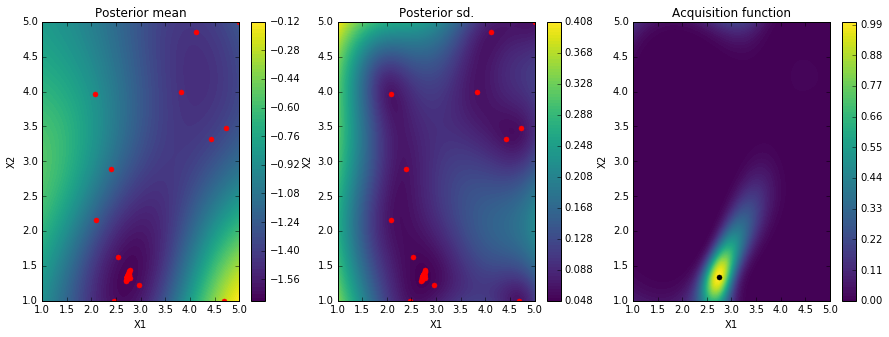

In [8]:
solver.plot_acquisition()

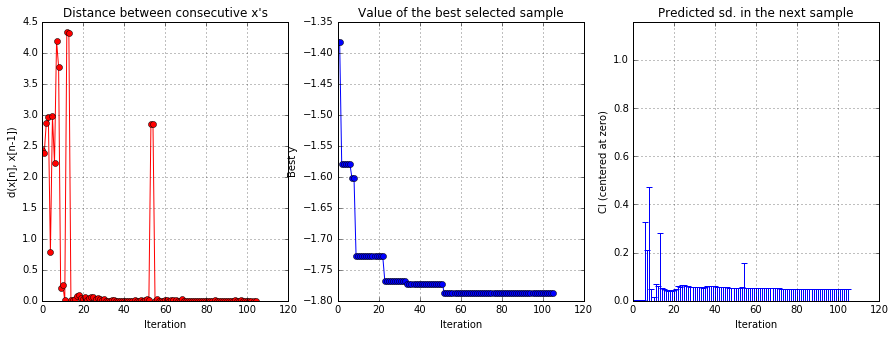

In [9]:
solver.plot_convergence()

In [13]:
solver.x_opt

array([ 2.73410129,  1.35314488])

In [14]:
g

NameError: name 'g' is not defined

In [15]:
gk3 = GK(A=solver.x_opt[0], B=solver.x_opt[1], g=true_g, k=true_k)
X_3 = gk3.rvs(10000)

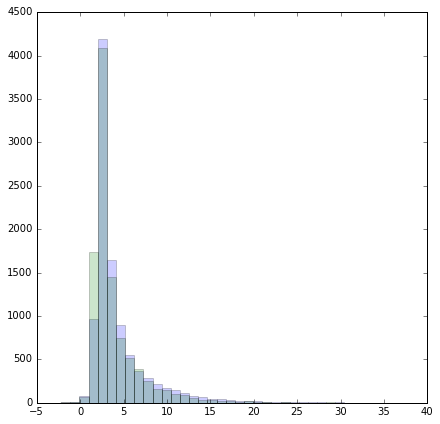

In [17]:
counts, bins, patches = plt.hist(X_true, bins=40, alpha=.2)
_ = plt.hist(X_3, bins=bins, alpha=.2)